In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    train_test_split, 
    RepeatedStratifiedKFold, 
    cross_val_score, 
    GridSearchCV,
    StratifiedKFold)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, 
    classification_report, 
    make_scorer,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    matthews_corrcoef)

In [2]:
train_df = pd.read_csv('combined_train_with_labels.csv.gz')
train_df

,id,energy_label,psd_label_low_avse,psd_label_high_avse,psd_label_dcr,psd_label_lq,tp0,ED,HWP,LQ80,...,current_kurtosis,total_power,time_to_main_peak,time_to_peak,late_over_early,tdrift99,tfr,peak_count,gbn,bpr
0,0_train_0,582.364295,False,True,True,True,957,3409.0,2299.0,-717094.898532,...,2.117825,1.709302e+09,85,85,0.987910,85.0,0.142357,3,1.198436,0.059642
1,1_train_0,250.159995,False,True,True,True,948,3404.0,2446.0,-331957.541919,...,2.058622,2.991376e+08,87,87,0.988301,87.0,0.151160,3,1.381123,0.061975
2,2_train_0,1212.323954,False,True,False,True,965,3411.0,2262.0,-425532.152706,...,-0.067003,6.244385e+08,95,95,0.987491,95.0,0.142606,3,1.361857,0.050813
3,3_train_0,240.878110,False,True,True,False,927,3408.0,2833.0,-306980.459766,...,2.443885,2.811583e+08,116,116,0.988450,116.0,0.133192,2,1.165654,0.062954
4,4_train_0,285.124189,False,True,True,False,958,3406.0,2397.0,-362746.925366,...,-0.173890,3.885442e+08,94,94,0.988541,94.0,0.145504,7,1.390918,0.055013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039995,1039995_train_15,210.834626,True,True,True,True,949,3403.0,2533.0,-278607.352936,...,2.026649,2.133856e+08,90,90,0.985736,90.0,0.151747,6,1.008092,0.062825
1039996,1039996_train_15,380.170340,True,True,True,True,949,3404.0,2426.0,-477777.966558,...,1.943512,6.842378e+08,82,82,0.987814,79.0,0.150305,3,1.245492,0.062706
1039997,1039997_train_15,370.109563,False,True,True,True,947,3409.0,2417.0,-466589.983952,...,1.601361,6.641180e+08,102,102,0.987833,102.0,0.142950,2,1.149456,0.062153
1039998,1039998_train_15,98.258524,True,True,True,False,921,3400.0,3799.0,-143212.214717,...,3.825219,4.630840e+07,92,92,0.989948,92.0,0.153135,5,1.192639,0.065264


# MODEL TRAINING

## Model Training - psd_label_high_avse

### Baseline Model - Logistic Regression

In [3]:
label_cols = [
    "psd_label_lq",
    "psd_label_high_avse",
    "psd_label_low_avse",
    "psd_label_dcr",
    "energy_label",
]

feature_cols = [col for col in train_df.columns if col not in label_cols + ['id']]

In [4]:
feature_cols

['tp0',
 'ED',
 'HWP',
 'LQ80',
 'PPR',
 'SC',
 'current_skewness',
 'spectral_centroid_power',
 'tail_charge_diff',
 'current_kurtosis',
 'total_power',
 'time_to_main_peak',
 'time_to_peak',
 'late_over_early',
 'tdrift99',
 'tfr',
 'peak_count',
 'gbn',
 'bpr']

In [5]:
pd.concat([train_df["psd_label_high_avse"].value_counts(), 
           train_df["psd_label_high_avse"].value_counts(normalize=True)], axis=1)

,count,proportion
psd_label_high_avse,,
True,1031559,0.991884
False,8441,0.008116


In [6]:
# DATA PREP
X = train_df[feature_cols]
y = train_df["psd_label_high_avse"]

In [7]:
# SPLIT
# We split first to protect the final test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y 
)

In [54]:
# Baseline performance
pipe_baseline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="lbfgs"
    ))
])

# Train
pipe_baseline.fit(X_train, y_train)

# Predict 
y_pred_baseline = pipe_baseline.predict(X_test)

              precision    recall  f1-score   support

       False       0.07      0.83      0.14      1688
        True       1.00      0.91      0.95    206312

    accuracy                           0.91    208000
   macro avg       0.54      0.87      0.55    208000
weighted avg       0.99      0.91      0.95    208000

AUC-PR Score: 0.2184
(Baseline/Random would be: 0.0081)
MCC Score: 0.2325


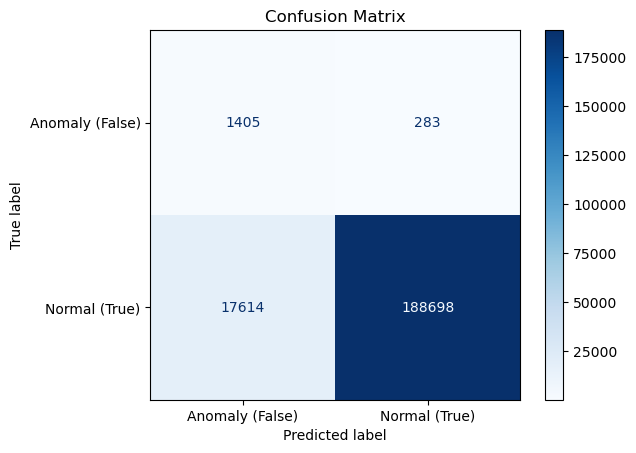

In [34]:
# Evaluate
# main classification metrics
print(classification_report(y_test, y_pred_baseline))

y_test_flipped = (~y_test)
# We need probabilities, not just predictions, for the curve
y_probs = pipe_baseline.predict_proba(X_test)[:, 0] # Prob of class 0 (False/Anomaly)

# AUC-PR
auc_pr = average_precision_score(y_test_flipped, y_probs)
print(f"AUC-PR Score: {auc_pr:.4f}")
print(f"(Baseline/Random would be: {y_test_flipped.mean():.4f})")

# MCC
mcc = matthews_corrcoef(y_test, y_pred_baseline)
print(f"MCC Score: {mcc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_baseline)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly (False)', 'Normal (True)'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [64]:
# HYPERPARAMETER TUNING (Find the Best Version)
# tune the 'lr' (Logistic Regression) part of the pipe
param_grid = {
    # 'lr__penalty': ['l1', 'l2'],    # Compare "feature selection" (l1) vs "shrinkage" (l2)
    'lr__class_weight': ['balanced', {0:5, 1:1}, {0:10, 1:1}, {0:25, 1:1}, {0:50, 1:1}],
    'lr__C': [0.1, 1, 10]   # Tune regularization strength
}

scoring_metrics = {
    'MCC': make_scorer(matthews_corrcoef),
    'False_F1': make_scorer(f1_score, pos_label=False),
    'True_F1': make_scorer(f1_score, pos_label=True),
    'AUC_PR': make_scorer(average_precision_score, response_method="predict_proba", pos_label=False)
}
scorer = make_scorer(f1_score, pos_label=False)

# Use Standard Stratified K-Fold for speed during the search
grid = GridSearchCV(
    estimator=pipe_baseline,        
    param_grid=param_grid, 
    cv=StratifiedKFold(n_splits=5), 
    scoring=scoring_metrics,
    refit='MCC',
    n_jobs=-1,
    verbose=1
)

print("Tuning hyperparameters...")
grid.fit(X_train, y_train) # runs the internal CV loops

Tuning hyperparameters...
Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=2000))]),
             n_jobs=-1,
             param_grid={'lr__C': [0.1, 1, 10],
                         'lr__class_weight': ['balanced', {0: 5, 1: 1},
                                              {0: 10, 1: 1}, {0: 25, 1: 1},
                                              {0: 50, 1: 1}]},
             refit='MCC',
             scoring={'AUC_PR': make_scorer(average_precision_score, response_method='predict_proba', pos_label=False),
                      'False_F1': make_scorer(f1_score, response_method='predict', pos_label=False),
                      'MCC': make_scorer(matthews_corrcoef, response_method='predict'),
                      'True_F1': make_scorer(f1_score, response_method='predict', pos_label=True)},
             verbose=1)

In [65]:
# RESULTS VISUALIZATION
# Convert the results dictionary to a DataFrame
cv_results = grid.cv_results_
results_df = pd.DataFrame(cv_results)

# Filter for the columns we want to see
columns_to_keep = [
    "param_lr__C", 
    "param_lr__class_weight",
    "rank_test_MCC",
    "mean_test_MCC",
    "mean_test_AUC_PR",
    "mean_test_False_F1",
    "mean_test_True_F1",
]

# Create a clean view sorted by best performance
clean_results = results_df[columns_to_keep].sort_values(by="rank_test_MCC")

pd.set_option('display.max_colwidth', None) # Show full param dict

clean_results

,param_lr__C,param_lr__class_weight,rank_test_MCC,mean_test_MCC,mean_test_AUC_PR,mean_test_False_F1,mean_test_True_F1
11,10,"{0: 5, 1: 1}",1,0.360069,0.270967,0.357848,0.995575
6,1,"{0: 5, 1: 1}",2,0.359924,0.270917,0.357702,0.995575
1,0.1,"{0: 5, 1: 1}",3,0.359584,0.271033,0.357333,0.995574
7,1,"{0: 10, 1: 1}",4,0.344995,0.266142,0.350307,0.994544
12,10,"{0: 10, 1: 1}",5,0.344930,0.266102,0.350242,0.994545
2,0.1,"{0: 10, 1: 1}",6,0.344845,0.266083,0.350160,0.994543
8,1,"{0: 25, 1: 1}",7,0.312313,0.249071,0.301652,0.991396
3,0.1,"{0: 25, 1: 1}",8,0.312201,0.249064,0.301575,0.991399
13,10,"{0: 25, 1: 1}",9,0.312151,0.249019,0.301514,0.991396
4,0.1,"{0: 50, 1: 1}",10,0.301138,0.240757,0.237580,0.982034


In [66]:
# Get the best model
best_model = grid.best_estimator_
print(f"Best Params found: {grid.best_params_}")
print(f"Mean MCC: {grid.best_score_}")

# Extract the Logistic Regression step and its coefficients
coefficients = best_model.named_steps['lr'].coef_[0]

# Create df
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': coefficients,
    'Abs_Importance': abs(coefficients)
})

# Sort by Absolute Importance (biggest impact at the top)
feature_importance = feature_importance.sort_values(by='Abs_Importance', ascending=False)

# REPORTING (TEXT)
# Use an option context to force Pandas to print the WHOLE list, not just top/bottom
print(f"\n--- FULL FEATURE RANKING: Impact of All {len(feature_importance)} Features on High AVSE ---")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(feature_importance[['Feature', 'Coefficient']])

Best Params found: {'lr__C': 10, 'lr__class_weight': {0: 5, 1: 1}}
Mean MCC: 0.36006859151628

--- FULL FEATURE RANKING: Impact of All 19 Features on High AVSE ---
                    Feature  Coefficient
9          current_kurtosis     1.035555
12             time_to_peak    -0.781299
2                       HWP    -0.316766
1                        ED     0.292857
6          current_skewness    -0.286055
15                      tfr    -0.282504
0                       tp0    -0.268083
10              total_power    -0.261171
11        time_to_main_peak     0.248730
4                       PPR    -0.246762
17                      gbn     0.142795
16               peak_count     0.097827
7   spectral_centroid_power     0.051531
5                        SC     0.045245
14                 tdrift99     0.040218
13          late_over_early    -0.022615
8          tail_charge_diff     0.020485
18                      bpr     0.008679
3                      LQ80     0.001800



Final Test Set Performance (20% Hold-out):
              precision    recall  f1-score   support

       False       0.42      0.28      0.34      1688
        True       0.99      1.00      1.00    206312

    accuracy                           0.99    208000
   macro avg       0.71      0.64      0.67    208000
weighted avg       0.99      0.99      0.99    208000

AUC-PR Score: 0.2453
(Baseline/Random would be: 0.0081)
MCC Score: 0.3404


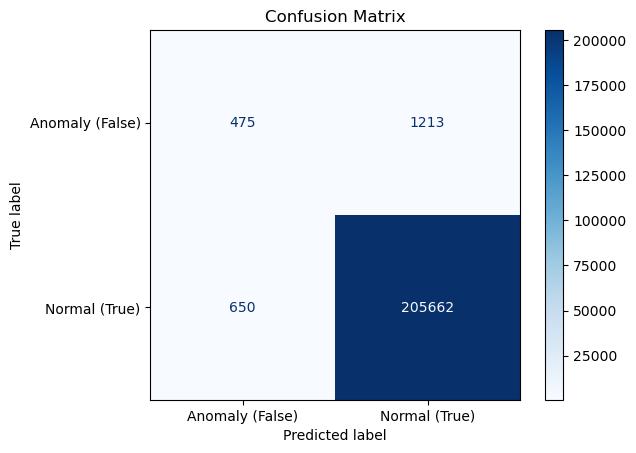

In [69]:
# EVALUATION
print("\nFinal Test Set Performance (20% Hold-out):")
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

y_test_flipped = (~y_test)
# We need probabilities, not just predictions, for the curve
y_probs = best_model.predict_proba(X_test)[:, 0] # Prob of class 0 (False/Anomaly)

# AUC-PR
auc_pr = average_precision_score(y_test_flipped, y_probs)
print(f"AUC-PR Score: {auc_pr:.4f}")
print(f"(Baseline/Random would be: {y_test_flipped.mean():.4f})")

# MCC
mcc = matthews_corrcoef(y_test, y_pred)
print(f"MCC Score: {mcc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly (False)', 'Normal (True)'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()